In [ ]:
# !wget -c https://www.dropbox.com/s/8lqrloi0mxj2acu/PH2Dataset.rar

# если по ссылке слишком много запросов, датасет можно скачать с kaggle: https://www.kaggle.com/datasets/kanametov/ph2dataset

In [ ]:
# from google.colab import drive
# drive.mount('/content/gdrive/')

In [ ]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

mv: cannot stat 'kaggle.json': No such file or directory


In [ ]:
!kaggle datasets download -d kanametov/ph2dataset

ph2dataset.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
!unzip -q ph2dataset.zip

replace PH2Dataset/PH2_Dataset/IMD002/IMD002_Dermoscopic_Image/IMD002.bmp? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
!ls

gdrive	PH2Dataset  ph2dataset.zip  sample_data


In [ ]:
# get_ipython().system_raw("unrar x PH2Dataset.rar")

Стуктура датасета у нас следующая:

    IMD_002/
        IMD002_Dermoscopic_Image/
            IMD002.bmp
        IMD002_lesion/
            IMD002_lesion.bmp
        IMD002_roi/
            ...
    IMD_003/
        ...
        ...

 Здесь `X.bmp` — изображение, которое нужно сегментировать, `X_lesion.bmp` — результат сегментации.

Для загрузки датасета можно использовать skimage: [`skimage.io.imread()`](https://scikit-image.org/docs/dev/api/skimage.io.html)

In [1]:
from skimage.io import imread
import glob
import os

root = 'PH2Dataset/PH2_Dataset/'

images = []
lesions = []

image_pattern = os.path.join(root, '*', '*_Dermoscopic_Image', '*.bmp')
lesion_pattern = os.path.join(root, '*', '*_lesion', '*.bmp')

image_files = glob.glob(image_pattern)
lesion_files = glob.glob(lesion_pattern)

for image_file, lesion_file in zip(image_files, lesion_files):
    images.append(imread(image_file))
    lesions.append(imread(lesion_file))

In [2]:
# images = []
# lesions = []
# from skimage.io import imread
# import os
# from glob import glob

# root = 'PH2Dataset/PH2_Dataset/'

# for root, dirs, files in os.walk(os.path.join(root, 'PH2 Dataset images')):
#     if root.endswith('_Dermoscopic_Image'):
#         images.append(imread(os.path.join(root, files[0])))
#     if root.endswith('_lesion'):
#         lesions.append(imread(os.path.join(root, files[0])))

Изображения имеют разные размеры. Давайте изменим их размер на $256\times256 $ пикселей. Для изменения размера изображений можно использовать [`skimage.transform.resize()`](https://scikit-image.org/docs/dev/api/skimage.transform.html#skimage.transform.resize).
Эта функция также автоматически нормализует изображения в диапазоне $[0,1]$.


In [3]:
from skimage.transform import resize
size = (256, 256)
X = [resize(x, size, mode='constant', anti_aliasing=True,) for x in images]
Y = [resize(y, size, mode='constant', anti_aliasing=False) > 0.5 for y in lesions]

In [4]:
import numpy as np
X = np.array(X, np.float32)
Y = np.array(Y, np.float32)
print(f'Loaded {len(X)} images')

Loaded 200 images


In [5]:
len(lesions)

200

Чтобы убедиться, что все корректно, мы нарисуем несколько изображений

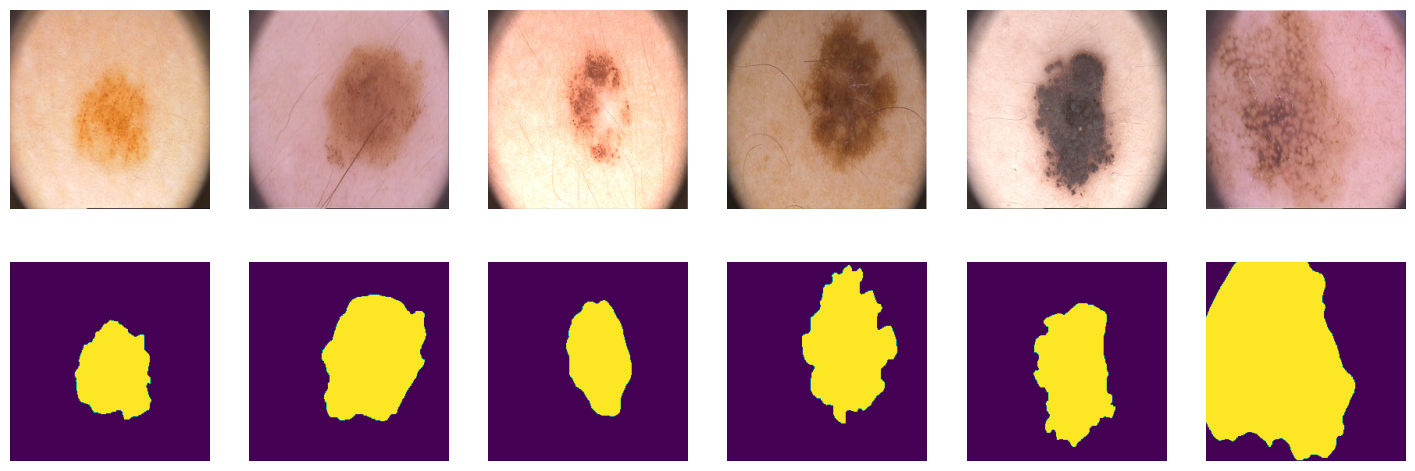

In [6]:
import matplotlib.pyplot as plt
from IPython.display import clear_output

plt.figure(figsize=(18, 6))
for i in range(6):
    plt.subplot(2, 6, i+1)
    plt.axis("off")
    plt.imshow(X[i])

    plt.subplot(2, 6, i+7)
    plt.axis("off")
    plt.imshow(Y[i])
plt.show();

Разделим наши 200 картинок на 100/50/50
 для обучения, валидации и теста соответственно

In [7]:
ix = np.random.choice(len(X), len(X), False)
tr, val, ts = np.split(ix, [100, 150])

In [8]:
print(len(tr), len(val), len(ts))

100 50 50


#### PyTorch DataLoader

In [9]:
from torch.utils.data import DataLoader
batch_size = 10
data_tr = DataLoader(list(zip(np.rollaxis(X[tr], 3, 1), Y[tr, np.newaxis])),
                     batch_size=batch_size, shuffle=True)
data_val = DataLoader(list(zip(np.rollaxis(X[val], 3, 1), Y[val, np.newaxis])),
                      batch_size=batch_size, shuffle=True)
data_ts = DataLoader(list(zip(np.rollaxis(X[ts], 3, 1), Y[ts, np.newaxis])),
                     batch_size=batch_size, shuffle=True)

In [10]:
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


# Реализация различных архитектур:
Ваше задание будет состоять в том, чтобы написать несколько нейросетевых архитектур для решения задачи семантической сегментации. Сравнить их по качеству на тесте и испробовать различные лосс функции для них.

-----------------------------------------------------------------------------------------

# SegNet [2 балла]

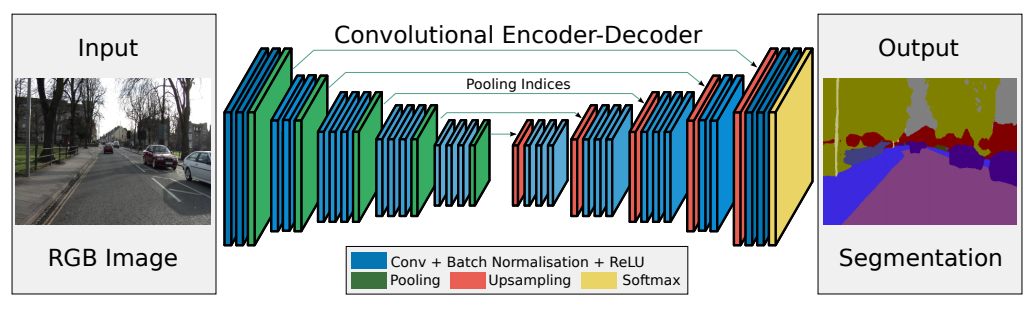

* Badrinarayanan, V., Kendall, A., & Cipolla, R. (2015). [SegNet: A deep convolutional
encoder-decoder architecture for image segmentation](https://arxiv.org/pdf/1511.00561.pdf)

Внимательно посмотрите из чего состоит модель и для чего выбраны те или иные блоки.

In [11]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
import torch.optim as optim
from time import time

from matplotlib import rcParams
rcParams['figure.figsize'] = (15,4)

In [12]:
import torch.nn as nn

class SegNet(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(SegNet, self).__init__()

        # Encoder (downsampling)
        self.enc_conv0 = nn.Sequential(
            nn.Conv2d(in_channels, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
        )
        self.pool0 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.enc_conv1 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
        )
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.enc_conv2 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(256),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(256),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(256),
        )
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.enc_conv3 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(512),
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(512),
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(512),
        )
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Bottleneck
        self.bottleneck_conv = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(512),
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(512),
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(512),
        )

        # Decoder (upsampling)
        self.upsample0 = nn.Upsample(scale_factor=2, mode='bilinear')
        self.dec_conv0 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(512),
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(512),
            nn.Conv2d(512, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(256),
        )

        self.upsample1 = nn.Upsample(scale_factor=2, mode='bilinear')
        self.dec_conv1 = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(256),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(256),
            nn.Conv2d(256, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
        )

        self.upsample2 = nn.Upsample(scale_factor=2, mode='bilinear')
        self.dec_conv2 = nn.Sequential(
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
        )

        self.upsample3 = nn.Upsample(scale_factor=2, mode='bilinear')
        self.dec_conv3 = nn.Sequential(
            nn.Conv2d(64, out_channels, kernel_size=3, stride=1, padding=1),
            # No activation in the last layer for segmentation
        )

    def forward(self, x):
        # Encoder
        e0 = self.enc_conv0(x)
        e1 = self.pool0(e0)
        e2 = self.enc_conv1(e1)
        e3 = self.pool1(e2)
        e4 = self.enc_conv2(e3)
        e5 = self.pool2(e4)
        e6 = self.enc_conv3(e5)
        e7 = self.pool3(e6)

        # Bottleneck
        b = self.bottleneck_conv(e7)

        # Decoder
        d0 = self.upsample0(b)
        d0 = self.dec_conv0(d0)
        d1 = self.upsample1(d0)
        d1 = self.dec_conv1(d1)
        d2 = self.upsample2(d1)
        d2 = self.dec_conv2(d2)
        d3 = self.upsample3(d2)
        d3 = self.dec_conv3(d3)

        return d3


In [13]:
def iou_pytorch(outputs: torch.Tensor, labels: torch.Tensor):
    # You can comment out this line if you are passing tensors of equal shape
    # But if you are passing output from UNet or something it will most probably
    # be with the BATCH x 1 x H x W shape
    outputs = outputs.squeeze(1) # BATCH x 1 x H x W => BATCH x H x W
    labels = labels.squeeze(1).byte()
    print(outputs)
    print(labels)
    SMOOTH = 1e-8
    intersection = (outputs & labels).float().sum((1, 2))  # Will be zero if Truth=0 or Prediction=0
    union = (outputs | labels).float().sum((1, 2))         # Will be zzero if both are 0

    iou = (intersection + SMOOTH) / (union + SMOOTH)  # We smooth our devision to avoid 0/0

    thresholded = torch.clamp(20 * (iou - 0.5), 0, 10).ceil() / 10  # This is equal to comparing with thresolds

    return thresholded  #

def iou_score(logits, labels, threshold=0.5):
    predictions = (torch.sigmoid(logits) > threshold).float()

    intersection = torch.sum(predictions * labels)
    union = torch.sum(predictions) + torch.sum(labels) - intersection

    iou = intersection / union if union != 0 else 0.0
    return iou.item()


## Функция потерь [1 балл]

Не менее важным, чем построение архитектуры, является определение **оптимизатора** и **функции потерь.**

Функция потерь - это то, что мы пытаемся минимизировать. Многие из них могут быть использованы для задачи бинарной семантической сегментации.

Популярным методом для бинарной сегментации является *бинарная кросс-энтропия*, которая задается следующим образом:

$$\mathcal L_{BCE}(y, \hat y) = -\sum_i \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

где $y$ это  таргет желаемого результата и $\hat y$ является выходом модели. $\sigma$ - это [*логистическая* функция](https://en.wikipedia.org/wiki/Sigmoid_function), который преобразует действительное число $\mathbb R$ в вероятность $[0,1]$.

Однако эта потеря страдает от проблем численной нестабильности. Самое главное, что $\lim_{x\rightarrow0}\log(x)=\infty$ приводит к неустойчивости в процессе оптимизации. Рекомендуется посмотреть следующее [упрощение](https://www.tensorflow.org/api_docs/python/tf/nn/sigmoid_cross_entropy_with_logits). Эта функция эквивалентна первой и не так подвержена численной неустойчивости:

$$\mathcal L_{BCE} = \hat y - y\hat y + \log\left(1+\exp(-\hat y)\right).$$

In [14]:
def bce_loss(y_real, y_pred):
    y_pred = torch.clamp(y_pred, min=1e-7, max=1-1e-7)

    loss = - (y_real * torch.log(y_pred) + (1 - y_real) * torch.log(1 - y_pred))

    loss = torch.mean(loss)

    return loss

## Тренировка [1 балл]

Мы определим цикл обучения в функции, чтобы мы могли повторно использовать его.

In [15]:
def train(model, opt, loss_fn, epochs, data_tr, data_val):
    X_val, Y_val = next(iter(data_val))

    train_losses = []
    val_losses = []
    for epoch in range(epochs):
        tic = time()
        print('* Epoch %d/%d' % (epoch+1, epochs))

        avg_loss = 0
        model.train()  # train mode
        for X_batch, Y_batch in data_tr:
            # data to device
            X_batch, Y_batch = X_batch.to(device), Y_batch.to(device)
            # set parameter gradients to zero
            opt.zero_grad()
            # forward
            Y_pred = model(X_batch)
            loss = loss_fn(Y_pred, Y_batch) # forward-pass
            # backward-pass
            loss.backward()
            # update weights
            opt.step()

            # calculate loss to show the user
            avg_loss += loss.item() / len(data_tr)
        train_losses.append(avg_loss)
        toc = time()
        print('Train Loss: %f' % avg_loss)

        # show intermediate results
        model.eval()  # testing mode
        Y_hat = model(X_val.to(device)).cpu().detach() # detach and put into cpu
        Y_val_pred = model(X_val.to(device))
        val_loss = loss_fn(Y_val_pred, Y_val.to(device)).item() / len(data_val)
        val_losses.append(val_loss)
        print('Validation Loss: %f' % val_loss)

        # Visualize tools
        clear_output(wait=True)
        for k in range(6):
            plt.subplot(2, 6, k+1)
            plt.imshow(np.rollaxis(X_val[k].numpy(), 0, 3), cmap='gray')
            plt.title('Real')
            plt.axis('off')

            plt.subplot(2, 6, k+7)
            plt.imshow(Y_hat[k, 0], cmap='gray')
            plt.title('Output')
            plt.axis('off')
        plt.suptitle('%d / %d - loss: %f' % (epoch+1, epochs, avg_loss))
        plt.show()

    return train_losses, val_losses

## Инференс [1 балл]

После обучения модели эту функцию можно использовать для прогнозирования сегментации на новых данных:

In [16]:
def predict(model, data):
    model.eval()  # testing mode
    Y_pred = [X_batch for X_batch, _ in data]
    return np.array(Y_pred)

In [17]:
def find_gt_mask(Y_pred, threshold=0.5):
    Y_pred_binary = (torch.sigmoid(Y_pred) > threshold).float()
    return Y_pred_binary

def score_model(model, metric, data, threshold=0.5):
    model.eval()  # testing mode
    scores = 0
    for X_batch, Y_label in data:
        X_batch, Y_label = X_batch.to(device), Y_label.to(device)
        Y_pred = model(X_batch)

        # Compute IoU score
        iou = metric(Y_pred, Y_label, threshold)

        print(f"IoU Score: {iou}")

        scores += iou

    return scores / len(data)


## Основной момент: обучение

Обучите вашу модель. Обратите внимание, что обучать необходимо до сходимости. Если указанного количества эпох (20) не хватило, попробуйте изменять количество эпох до сходимости алгоритма. Сходимость определяйте по изменению функции потерь на валидационной выборке.
 С параметрами оптимизатора можно спокойно играть, пока вы не найдете лучший вариант для себя.


In [ ]:
model = SegNet(3, 1).to(device)
# print(model)

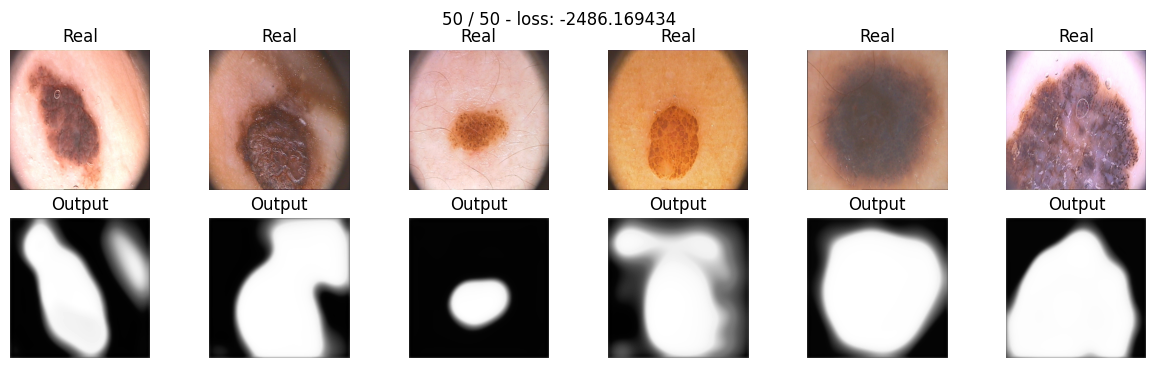

In [ ]:
max_epochs = 50
optimizer = optim.Adam(model.parameters(), lr=0.001)
train_losses, val_losses = train(model, optimizer, bce_loss, max_epochs, data_tr, data_val)

In [ ]:
score_model(model, iou_score, data_val, threshold=0.5)

IoU Score: 0.7442587018013
IoU Score: 0.7405906319618225


0.7424246668815613

In [28]:
 def plot_learning_curve(train_losses, val_losses):
      # Plot the learning curve
      plt.figure(figsize=(12, 5))
      plt.subplot(1, 2, 1)
      plt.plot(train_losses, label='Training Loss')
      plt.plot(val_losses, label='Validation Loss')
      plt.xlabel('Epoch')
      plt.ylabel('Loss')
      plt.legend()

Ответьте себе на вопрос: не переобучается ли моя модель?

Судя по кривой обучения, модель начинает переобучаться после примерно 30 эпох.

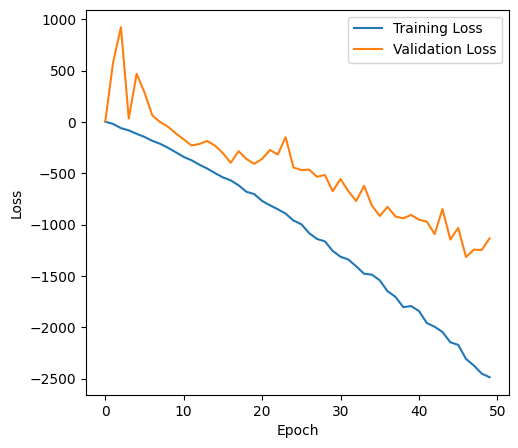

In [ ]:
plot_learning_curve(train_losses, val_losses)

## Дополнительные функции потерь [2 балла]

In [38]:
def dice_loss(outputs, labels, smooth=1e-5):
    outputs = torch.sigmoid(outputs)

    outputs_flat = outputs.view(-1)
    labels_flat = labels.view(-1)

    intersection = torch.sum(outputs_flat * labels_flat)
    union = torch.sum(outputs_flat) + torch.sum(labels_flat)

    dice_loss = 1 - (2 * intersection + smooth) / (union + smooth)

    return dice_loss

Проводим тестирование:

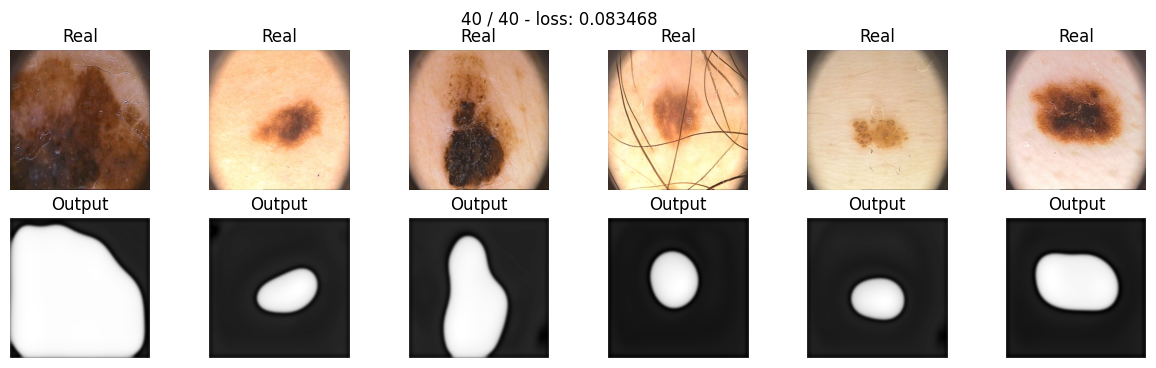

In [39]:
model_dice = SegNet(3, 1).to(device)

max_epochs = 40
optimaizer = optim.Adam(model_dice.parameters())
train_losses, val_losses = train(model_dice, optimaizer, dice_loss, max_epochs, data_tr, data_val)

In [40]:
score_model(model_dice, iou_score, data_val, threshold=0.5)

IoU Score: 0.6799101829528809
IoU Score: 0.723042368888855


0.7014762759208679

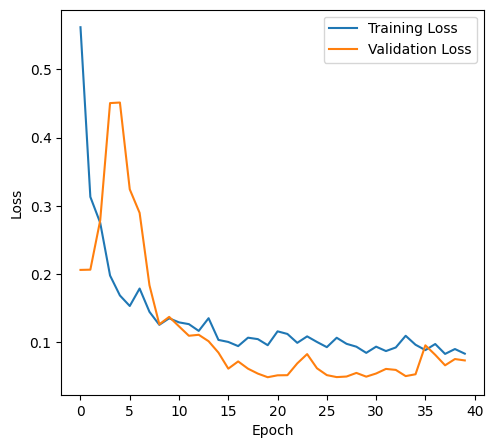

In [43]:
plot_learning_curve(train_losses, val_losses)

[**2. Focal loss:**](https://arxiv.org/pdf/1708.02002.pdf)

Окей, мы уже с вами умеем делать BCE loss:

$$\mathcal L_{BCE}(y, \hat y) = -\sum_i \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

Проблема с этой потерей заключается в том, что она имеет тенденцию приносить пользу классу **большинства** (фоновому) по отношению к классу **меньшинства** ( переднему). Поэтому обычно применяются весовые коэффициенты к каждому классу:

$$\mathcal L_{wBCE}(y, \hat y) = -\sum_i \alpha_i\left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

Традиционно вес $\alpha_i$ определяется как обратная частота класса этого пикселя $i$, так что наблюдения миноритарного класса весят больше по отношению к классу большинства.

Еще одним недавним дополнением является взвешенный пиксельный вариант, которая взвешивает каждый пиксель по степени уверенности, которую мы имеем в предсказании этого пикселя.

$$\mathcal L_{focal}(y, \hat y) = -\sum_i \left[\left(1-\sigma(\hat y_i)\right)^\gamma y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

Зафиксируем значение $\gamma=2$.

--------------------------------------------------------------------------------


In [46]:
def focal_loss(y_real, y_pred, eps = 1e-8, gamma = 2):
    y_pred = torch.clamp(y_pred, eps, 1.0 - eps)

    focal_loss = -torch.sum(y_real * (1 - y_pred) ** gamma * torch.log(y_pred))

    return focal_loss


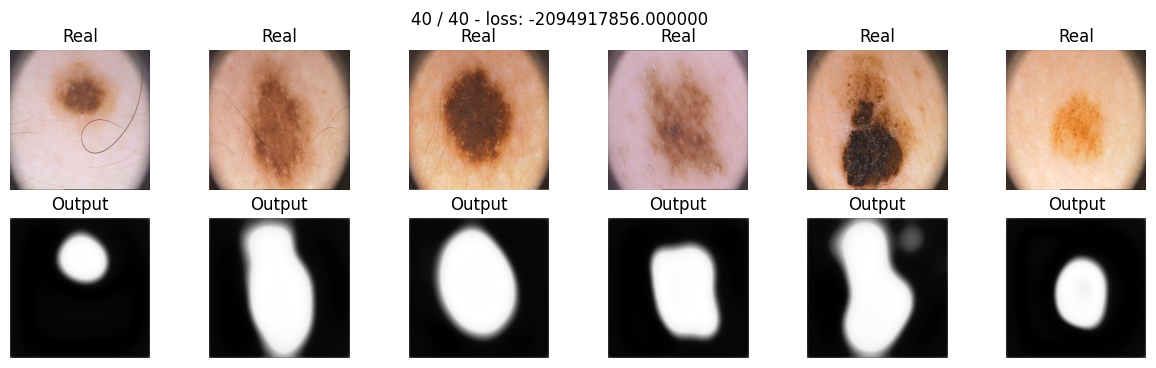

In [47]:
model_focal = SegNet(3, 1).to(device)

max_epochs = 40
optimaizer = optim.Adam(model_focal.parameters())
train_losses, val_losses = train(model_focal, optimaizer, focal_loss, max_epochs, data_tr, data_val)

In [48]:
score_model(model_dice, iou_score, data_val, threshold=0.5)

IoU Score: 0.7121374607086182
IoU Score: 0.6939781904220581


0.7030578255653381

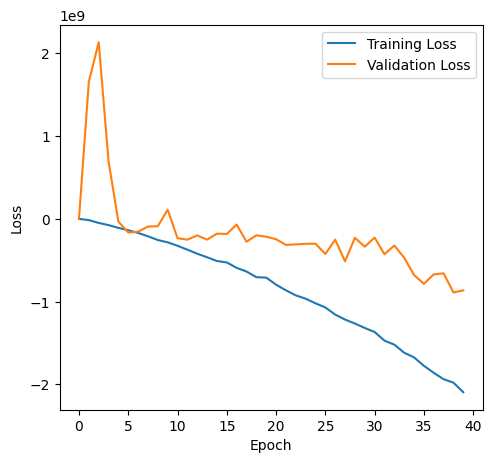

In [49]:
plot_learning_curve(train_losses, val_losses)

----------------------------------------------------------------------------------------------

## [BONUS] Мир сегментационных лоссов [5 баллов]

В данном блоке предлагаем вам написать одну функцию потерь самостоятельно. Для этого необходимо прочитать статью и имплементировать ее. Кроме тако провести численное сравнение с предыдущими функциями.
Какие варианты?

1) Можно учесть Total Variation
2) Lova
3) BCE но с Soft Targets (что-то типа label-smoothing для многослассовой классификации)
4) Любой другой

* [Physiological Inspired Deep Neural Networks for Emotion Recognition](https://ieeexplore.ieee.org/stamp/stamp.jsp?arnumber=8472816&tag=1)". IEEE Access, 6, 53930-53943.

* [Boundary loss for highly unbalanced segmentation](https://arxiv.org/abs/1812.07032)

* [Tversky loss function for image segmentation using 3D fully convolutional deep networks](https://arxiv.org/abs/1706.05721)

* [Correlation Maximized Structural Similarity Loss for Semantic Segmentation](https://arxiv.org/abs/1910.08711)

* [Topology-Preserving Deep Image Segmentation](https://papers.nips.cc/paper/8803-topology-preserving-deep-image-segmentation)

Так как Тверский лосс очень похож на данные выше, то за него будет проставлено только 3 балла (при условии, если в модели нет ошибок при обучении). Постарайтесь сделать что-то интереснее.

In [ ]:
# Lovász-Softmax loss

In [ ]:
import torch
import torch.nn.functional as F

def lovasz_grad(gt_sorted):
    """
    Compute gradient of the Lovász hinge loss.
    """
    gts = torch.sum(gt_sorted)
    intersection = gts - torch.cumsum(gt_sorted, dim=0)
    union = gts + torch.cumsum(1 - gt_sorted, dim=0)
    jaccard = 1.0 - intersection / union
    jaccard = torch.cat((jaccard[0:1], jaccard[1:] - jaccard[:-1]))
    return jaccard

def lovasz_softmax_flat(logits, labels):
    """
    Compute the Lovász hinge loss for a flat prediction.
    """
    labels_size = labels.size()
    logits = logits.view(-1)
    labels = labels.view(-1)

    indices = torch.argsort(logits, descending=True)
    logits_sorted = logits[indices]
    labels_sorted = labels[indices]

    gt_sorted = labels_sorted.float()
    grad = lovasz_grad(gt_sorted)

    loss = torch.dot(F.relu(logits_sorted), grad)
    return loss

def lovasz_softmax(logits, labels):
    """
    Compute the Lovász hinge loss for a batch of predictions.
    """
    losses = []
    for logit, label in zip(logits, labels):
        losses.append(lovasz_softmax_flat(logit, label))
    return torch.stack(losses)

class LovaszSoftmaxLoss(torch.nn.Module):
    def __init__(self):
        super(LovaszSoftmaxLoss, self).__init__()

    def forward(self, logits, labels):
        return lovasz_softmax(logits, labels)


-----------------------------------------------------------------------------------------

# U-Net [2 балла]

[**U-Net**](https://arxiv.org/abs/1505.04597) — это архитектура нейронной сети, которая получает изображение и выводит его. Первоначально он был задуман для семантической сегментации (как мы ее будем использовать), но он настолько успешен, что с тех пор используется в других контекстах. Получая на вход медицинское изображение, он выведет изображение в оттенках серого, где интенсивность каждого пикселя зависит от вероятности того, что этот пиксель принадлежит интересующей нас области.

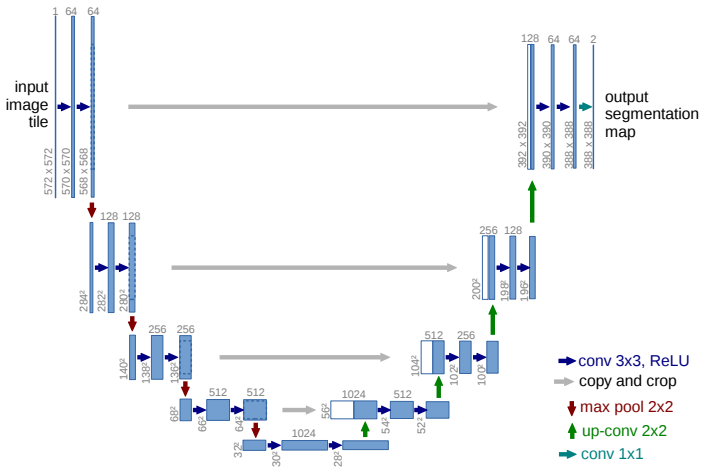

У нас в архитектуре все так же существует энкодер и декодер, как в **SegNet**, но отличительной особеностью данной модели являются *skip-conenctions*, соединяющие части декодера и энкодера. То есть для того чтобы передать на вход декодера тензор, мы конкатенируем симметричный выход с энкодера и выход предыдущего слоя декодера.

* Ronneberger, Olaf, Philipp Fischer, and Thomas Brox. "[U-Net: Convolutional networks for biomedical image segmentation.](https://arxiv.org/pdf/1505.04597.pdf)" International Conference on Medical image computing and computer-assisted intervention. Springer, Cham, 2015.

In [18]:
class double_conv(nn.Module):
    """(conv => BN => ReLU) * 2"""

    def __init__(self, in_ch, out_ch):
        super(double_conv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        x = self.conv(x)
        return x


class inconv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(inconv, self).__init__()
        self.conv = double_conv(in_ch, out_ch)

    def forward(self, x):
        x = self.conv(x)
        return x


class down(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(down, self).__init__()
        self.mpconv = nn.Sequential(nn.MaxPool2d(2), double_conv(in_ch, out_ch))

    def forward(self, x):
        x = self.mpconv(x)
        return x


class up(nn.Module):
    def __init__(self, in_ch, out_ch, bilinear=True):
        super(up, self).__init__()

        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode="bilinear", align_corners=True)
        else:
            self.up = nn.ConvTranspose2d(in_ch // 2, in_ch // 2, 2, stride=2)

        self.conv = double_conv(in_ch, out_ch)

    def forward(self, x1, x2):
        x1 = self.up(x1)

        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, (diffX // 2, diffX - diffX // 2, diffY // 2, diffY - diffY // 2))

        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)


class outconv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(outconv, self).__init__()
        self.conv = nn.Conv2d(in_ch, out_ch, 1)

    def forward(self, x):
        x = self.conv(x)
        return x


class UNet(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UNet, self).__init__()
        self.inc = inconv(in_channels, 64)
        self.down1 = down(64, 128)
        self.down2 = down(128, 256)
        self.down3 = down(256, 512)
        self.down4 = down(512, 512)
        self.up1 = up(1024, 256, True)
        self.up2 = up(512, 128, True)
        self.up3 = up(256, 64, True)
        self.up4 = up(128, 64, True)
        self.outc = outconv(64, out_channels)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        x = self.outc(x)
        return x

In [19]:
unet_model = UNet(3, 1).to(device)

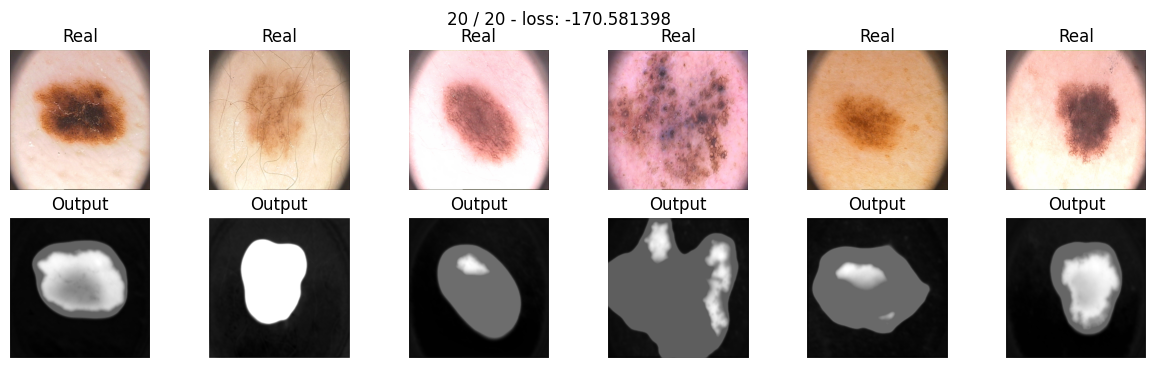

In [20]:
train_losses, val_losses = train(unet_model, optim.Adam(unet_model.parameters()), bce_loss, 20, data_tr, data_val)

In [22]:
score_model(unet_model, iou_score, data_val, threshold=0.5)

IoU Score: 0.22994689643383026
IoU Score: 0.21131233870983124
IoU Score: 0.3004058301448822
IoU Score: 0.3854422867298126
IoU Score: 0.4888579547405243


0.3231930613517761

In [23]:
plot_learning_curve(train_losses, val_losses)

NameError: ignored

Новая модель путем изменения типа пулинга:

 **Max-Pooling** for the downsampling and **nearest-neighbor Upsampling** for the upsampling.

Down-sampling:

        conv = nn.Conv2d(3, 64, 3, padding=1)
        pool = nn.MaxPool2d(3, 2, padding=1)

Up-Sampling

        upsample = nn.Upsample(32)
        conv = nn.Conv2d(64, 64, 3, padding=1)

Замените max-pooling на convolutions с stride=2 и upsampling на transpose-convolutions с stride=2.


In [24]:
 class UNet2(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UNet2, self).__init__()
        self.inc = inconv(in_channels, 64)
        self.down1 = down(64, 128)
        self.down2 = down(128, 256)
        self.down3 = down(256, 512)
        self.down4 = down(512, 512)
        self.up1 = up(1024, 256, False)
        self.up2 = up(512, 128, False)
        self.up3 = up(256, 64, False)
        self.up4 = up(128, 64, False)
        self.outc = outconv(64, out_channels)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        x = self.outc(x)
        return x

In [25]:
unet2_model = UNet2(3, 1).to(device)


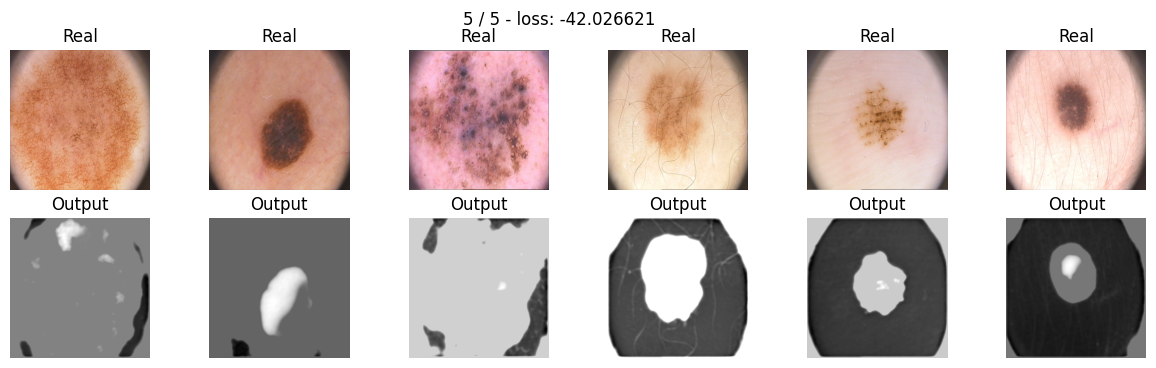

In [26]:
train_losses, val_losses = train(unet2_model, optim.Adam(unet2_model.parameters()), bce_loss, 5, data_tr, data_val)

In [27]:
score_model(unet2_model, iou_score, data_val, threshold=0.5)

IoU Score: 0.48698607087135315
IoU Score: 0.41722092032432556
IoU Score: 0.4132601320743561
IoU Score: 0.28300198912620544
IoU Score: 0.43610161542892456


0.407314145565033

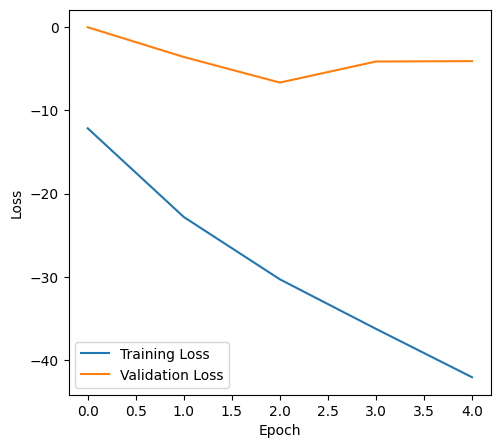

In [29]:
plot_learning_curve(train_losses, val_losses)

Сделайте вывод, какая из моделей лучше

Модель UNET с transpose-convolutions лучше судя по IOU score, на 5 эпохах достигнуто IOU score = 40 %, для UNET с Upsampling на 20 эпохах достигнуто только IOU score = 32 %

# Отчет (6 баллов)

**SegNet with binary cross-entropy (BCE) loss**

Prediction threshold = 0.5
batch_size = 25

| Num epochs | LR | IOU score, % |
|-----------|-----------|-----------|
| 20 | 0.001 (Adam opt) | 59 |
| 30 | 0.001 (Adam opt) | 68 |
| 40 | 0.001 (Adam opt) | 80 |


**SegNet with dice loss**

Prediction threshold = 0.5
batch_size = 25

| Num epochs | LR | IOU score, % |
|-----------|-----------|-----------|
| 40 | 0.001 (Adam opt) | 70 |

**SegNet with focal loss**

Prediction threshold = 0.5
batch_size = 25

| Num epochs | LR | IOU score, % |
|-----------|-----------|-----------|
| 40 | 0.001 (Adam opt) | 70 |


**UNET Upsample with binary cross-entropy (BCE) loss**

Prediction threshold = 0.5
batch_size = 10

| Num epochs | LR | IOU score, % |
|-----------|-----------|-----------|
| 20 | 0.001 (Adam opt) | 32 |

**UNET Transpose with binary cross-entropy (BCE) loss**

Prediction threshold = 0.5
batch_size = 10

| Num epochs | LR | IOU score, % |
|-----------|-----------|-----------|
| 5 | 0.001 (Adam opt) | 41 |